In [115]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.utils import resample
import xgboost as xgb
from scipy.stats import pearsonr

import imp
import llama

llama = imp.reload(llama)

In [63]:
train_df, test_X = llama.load_df("./data/train.csv", "./data/test.csv")
test_id = test_X.ID
test_X = test_X.drop("ID", 1)

Train DataFrame:
Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371)
(76020, 371)
---
Test DataFrame:
Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var29_ult3', 'saldo_medio_var33_hace2',
       'saldo_medio_var33_hace3', 'saldo_medio_var33_ult1',
       'saldo_medio_var33_ult3', 'saldo_medi

In [64]:
train_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,117235.809430,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,182664.598503,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5163.750000,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67870.612500,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,106409.160000,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,118756.252500,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,22034738.760000,1.000000


In [65]:
def replace_very_low_var3(df):
    pass

train_df.loc[train_df["delta_imp_aport_var17_1y3"] == 9999999999, :].head()

col_sizes = {}
for col in train_df.columns:
    if col != "TARGET" and col != "ID":
        col_sizes[col] = len(set(train_df[col])), len(set(test_X[col]))

from collections import Counter
Counter(dict(sorted(col_sizes.items(), key = lambda x: x[1], reverse = False)).values())
set(train_df["delta_num_aport_var13_1y3"]), set(test_X["delta_num_aport_var13_1y3"])

({-1.0, -0.5, -0.33333333300000001, 0.0, 1.0, 9999999999.0},
 {-1.0, -0.5, 0.0, 1.0, 2.0, 3.0, 9999999999.0})

In [66]:
print(train_df.shape)
print(test_X.shape)

for key, val in col_sizes.items():
    if val == (1, 1):
        print(key)
        train_df.drop(key, 1, inplace=True)
        test_X.drop(key, 1, inplace=True)
        
print(train_df.shape)
print(test_X.shape)

(76020, 371)
(75818, 369)
num_var2_ult1
imp_reemb_var33_hace3
saldo_var2_ult1
saldo_var46
ind_var2_0
num_var28_0
ind_var2
ind_var27_0
num_var2_0_ult1
imp_reemb_var13_hace3
ind_var27
num_var27
ind_var28
imp_trasp_var33_out_hace3
num_reemb_var13_hace3
ind_var41
num_trasp_var33_out_hace3
ind_var46_0
num_trasp_var17_out_hace3
ind_var28_0
num_var28
imp_amort_var18_hace3
imp_amort_var34_hace3
num_var46_0
num_var41
saldo_var41
num_var46
saldo_medio_var13_medio_hace3
num_reemb_var33_hace3
saldo_var27
num_var27_0
ind_var46
imp_trasp_var17_out_hace3
saldo_var28
(76020, 337)
(75818, 335)


In [67]:
print(train_df.shape)
print(test_X.shape)

for key, val in col_sizes.items():
    if val == (2, 1) or val == (2, 2):
        print(key)
        train_df.loc[train_df[key] > 0, key] = 1
        test_X.loc[test_X[key] > 0, key] = 1
        
print(train_df.shape)
print(test_X.shape)

(76020, 337)
(75818, 335)
ind_var1_0
ind_var12
ind_var26
delta_imp_reemb_var33_1y3
ind_var1
ind_var13_medio_0
ind_var13_largo_0
num_reemb_var17_hace3
num_var39
delta_imp_amort_var34_1y3
ind_var41_0
ind_var6
num_reemb_var13_ult1
ind_var34_0
ind_var9_ult1
ind_var17_0
imp_reemb_var17_hace3
delta_imp_amort_var18_1y3
delta_imp_trasp_var33_out_1y3
ind_var6_0
ind_var37_cte
ind_var39_0
num_reemb_var33_ult1
ind_var5_0
ind_var29_0
ind_var32_0
ind_var12_0
num_var8
ind_var5
num_var20_0
ind_var33_0
ind_var10_ult1
num_var13_medio
ind_var43_recib_ult1
ind_var37_0
num_trasp_var33_in_hace3
ind_var13_medio
ind_var32_cte
ind_var34
ind_var13
ind_var10cte_ult1
ind_var25_cte
ind_var13_largo
ind_var17
ind_var30
delta_num_reemb_var13_1y3
num_trasp_var17_out_ult1
ind_var25_0
num_trasp_var33_out_ult1
delta_num_reemb_var33_1y3
num_var34
saldo_medio_var29_hace3
num_var6
ind_var44
ind_var7_recib_ult1
ind_var7_emit_ult1
num_var20
ind_var24_0
ind_var31_0
delta_imp_reemb_var13_1y3
num_var34_0
ind_var14_0
ind_var13_0


In [68]:
# New dummy features:
# var3 >= 16
# var3 == -999999, replace such var3 values with mean values
# var15 <= 22
# var38 <= 25
#
# Replace max with mean and add dummy variables:
# delta_imp_compra_var44_1y3
# delta_num_venta_var44_1y3
# delta_num_trasp_var33_in_1y3
# delta_num_trasp_var17_in_1y3
# delta_num_reemb_var17_1y3
# delta_num_compra_var44_1y3
# delta_num_aport_var33_1y3
# delta_num_aport_var17_1y3
# delta_imp_venta_var44_1y3
# delta_imp_trasp_var33_in_1y3
# delta_imp_aport_var13_1y3
# delta_imp_aport_var17_1y3
# delta_imp_aport_var33_1y3
# delta_imp_reemb_var17_1y3
# delta_num_aport_var13_1y3
# delta_imp_trasp_var17_in_1y3

feature = "var3"
train_df["dummy_" + feature] = 0
train_df.loc[train_df[feature] >= 16, "dummy_"+feature] = 1
test_X["dummy_" + feature] = 0
test_X.loc[test_X[feature] >= 16, "dummy_"+feature] = 1

mean_val = train_df.loc[train_df["var3"] != -999999, "var3"].mean()
train_df.loc[train_df["var3"] == -999999, "var3"] = mean_val
test_X.loc[test_X["var3"] == -999999, "var3"] = mean_val

feature = "var15"
train_df["dummy_" + feature] = 0
train_df.loc[train_df[feature] <= 22, "dummy_"+feature] = 1
test_X["dummy_" + feature] = 0
test_X.loc[test_X[feature] <= 22, "dummy_"+feature] = 1

feature = "var38"
train_df["dummy_" + feature] = 0
train_df.loc[train_df[feature] <= 25, "dummy_"+feature] = 1
test_X["dummy_" + feature] = 0
test_X.loc[test_X[feature] <= 25, "dummy_"+feature] = 1

delta_features = ['delta_imp_compra_var44_1y3', 'delta_num_venta_var44_1y3', 'delta_num_trasp_var33_in_1y3', 
                  'delta_num_trasp_var17_in_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_compra_var44_1y3', 
                  'delta_num_aport_var33_1y3', 'delta_num_aport_var17_1y3', 'delta_imp_venta_var44_1y3', 
                  'delta_imp_trasp_var33_in_1y3', 'delta_imp_aport_var13_1y3', 'delta_imp_aport_var17_1y3', 
                  'delta_imp_aport_var33_1y3', 'delta_imp_reemb_var17_1y3', 'delta_num_aport_var13_1y3', 
                  'delta_imp_trasp_var17_in_1y3']
for de_fe in delta_features:
    max_val = train_df[de_fe].max()
    mean_val = train_df.loc[train_df[de_fe] != max_val, de_fe].mean()
    train_df.loc[train_df[de_fe] == max_val, de_fe] = mean_val
    test_X.loc[test_X[de_fe] == max_val, de_fe] = mean_val

/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [337] are constant.
  UserWarning)


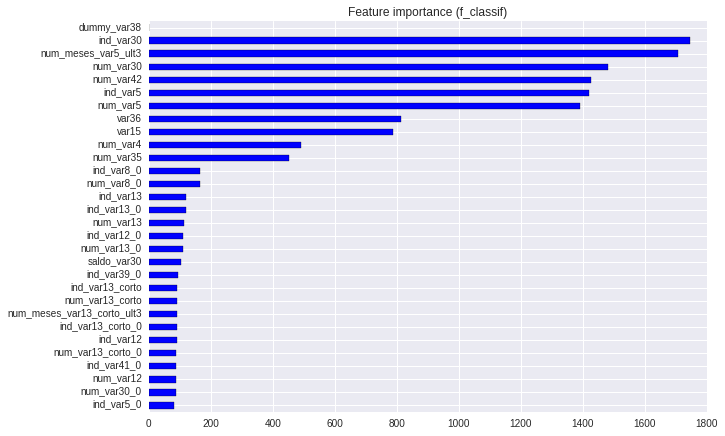

In [69]:
#
# Feature Selection
#
llama = imp.reload(llama)

train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
top_features = 30

# SelectKBest with ANOVA
feat_imp_anova = llama.anova_best_features(train_X, train_y, top_features)

In [70]:
# # RFECV
# llama = imp.reload(llama)

# train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
# indices = llama.downsample(train_y, [20000, 3000])
# train_X = train_X.loc[indices, :]
# train_y = train_y[indices]

# feat_imp_rfe_lin, feat_imp_rfe_log = llama.rfe_best_features(train_X, train_y)

In [71]:
# L1-based
# Randomized lasso
# feat_imp

In [72]:
# # # feat_imp.hist(by=1, sharex=True, sharey=True)
# feat_imp_na = feat_imp_rfe
# feat_imp_rfe = feat_imp_rfe.dropna()
# plt.figure(figsize=(14, 7))
# plt.hist(feat_imp_rfe.loc[feat_imp[1] == "Linear", 0], bins = 50, alpha=0.5, label='linear')
# plt.hist(feat_imp_rfe.loc[feat_imp[1] == "Logistic", 0], bins = 50, alpha=0.5, label='logistic')
# plt.legend(loc='upper right')
# plt.show()

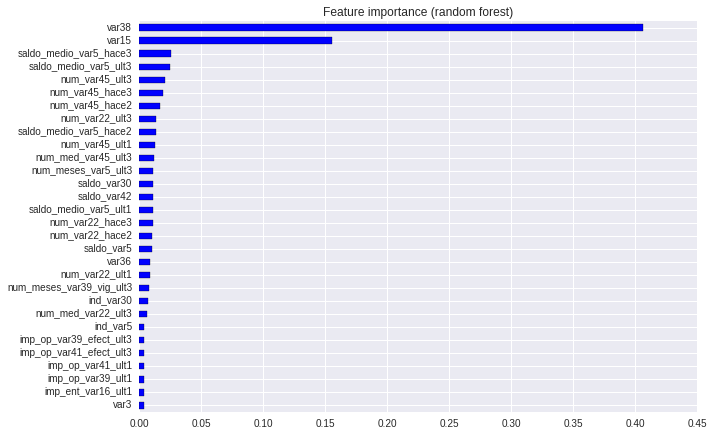

In [73]:
# Trees
llama = imp.reload(llama)
feat_imp_tree = llama.tree_best_features(train_X, train_y, top_features)

In [74]:
llama = imp.reload(llama)

train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
# train_X = resample(train_X, n_samples = 30000)

cv_fold = StratifiedKFold(train_y, n_folds = 5, shuffle = True)
cv_col = [cv for cv in cv_fold][0]
val_col = np.ndarray(shape = 1 + (max(cv_col[0].max(), cv_col[1].max())))
val_col[cv_col[0]] = 0
val_col[cv_col[1]] = 1
print(sum(train_y))
print(sum(train_df["TARGET"]))
print(sum(train_y[val_col] == 0))
print(sum(train_y[val_col] == 1))

3008
3008
76020
0


In [75]:
# feat_imp_anova.tail(70).plot(kind = "bar")

In [76]:
# feat_imp_rfe_log.sort_values().tail(100).plot(kind = "bar")

In [77]:
# feat_imp_rfe_lin.sort_values().tail(150).plot(kind = "bar")

In [78]:
# feat_imp_tree.tail(25).plot(kind = "bar")

In [ ]:
llama = imp.reload(llama)
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
tree25 = llama.train_xgb(train_X2, train_y, cv_fold)
print(tree25, file = "tree.model.txt")

/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1. Number of estimators... Done.
2. Weight scaling... Done.
3. Depth and child weights... Done.
4. Number of estimators... Done.
5. Gamma... Done.
6. Sample and colsample... Done.
7. Regularization... Done.
8. Number of estimators and the learning rate... Done.

/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metric


9. Weight scaling... Done.
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.5, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=600, nthread=7,
       objective='binary:logistic', reg_alpha=10, reg_lambda=10,
       scale_pos_weight=7, seed=0, silent=True, subsample=1.0)
CV scores: [ 0.84337777  0.84053685  0.83724025  0.83161778  0.83528491]
=>	0.837611511292 (+-0.00408124958341)


/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
llama = imp.reload(llama)
train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
xanova70 = llama.train_xgb(train_X2, train_y, cv_fold)
print(xanova70, file = "anova.model.txt")

/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


1. Number of estimators... Done.

/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



2. Weight scaling... Done.
3. Depth and child weights... Done.
4. Number of estimators... Done.
5. Gamma... Done.
6. Sample and colsample... Done.
7. Regularization... Done.
8. Number of estimators and the learning rate... Done.

/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/vadim/anaconda3/lib/python3.5/site-packages/sklearn/metric

In [85]:
xanova70
# llama = imp.reload(llama)
# train_X2 = llama.take_features(feat_imp_rfe_lin.sort_values().tail(110), train_X)[0]
# xlin110 = llama.train_xgb(train_X2, train_y, cv_fold)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1.0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1300, nthread=7,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=100,
       scale_pos_weight=7, seed=0, silent=True, subsample=0.9)

In [ ]:
# llama = imp.reload(llama)
# train_X2 = llama.take_features(feat_imp_rfe_log.sort_values().tail(45), train_X)[0]
# xlog45 = llama.train_xgb(train_X2, train_y, cv_fold)

In [86]:
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
clf1 = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.5, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=600, nthread=7,
       objective='binary:logistic', reg_alpha=10, reg_lambda=10,
       scale_pos_weight=7, seed=0, silent=True, subsample=1.0)
clf1.fit(train_X2, train_y)
llama.per_clf_report(clf1, train_X2, train_y, val_col, cv_fold)

train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
clf2 = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1.0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1300, nthread=7,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=100,
       scale_pos_weight=7, seed=0, silent=True, subsample=0.9)
clf2.fit(train_X2, train_y)
llama.per_clf_report(clf2, train_X2, train_y, val_col, cv_fold)

# train_X2 = llama.take_features(feat_imp_rfe_lin.sort_values().tail(110), train_X)[0]
# llama.per_clf_report(xlin110, train_X2, train_y, val_col, cv_fold)

# train_X2 = llama.take_features(feat_imp_rfe_log.sort_values().tail(45), train_X)[0]
# llama.per_clf_report(xlog45, train_X2, train_y, val_col, cv_fold)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.5, learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=3, missing=None, n_estimators=600, nthread=7,
       objective='binary:logistic', reg_alpha=10, reg_lambda=10,
       scale_pos_weight=7, seed=0, silent=True, subsample=1.0)
CV scores: [ 0.84337777  0.84053685  0.83724025  0.83161778  0.83528491]
=>	0.837611511292 (+-0.00408124958341)

Metrics:
             precision    recall  f1-score   support

          0       0.98      0.92      0.95     14603
          1       0.21      0.52      0.30       602

avg / total       0.95      0.90      0.92     15205

Confusion matrix:
Cls	0	1
0	13412	1191
1	287	315
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=1.0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=1300, nthread=7,
       objective='binary:logistic', reg_alpha=1e-05, reg_lambda=1

In [90]:
frs = RandomForestClassifier(n_jobs=7, n_estimators=2000)
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
frs.fit(train_X2, train_y)
llama.per_clf_report(frs, train_X2, train_y, val_col, cv_fold)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=7,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
CV scores: [ 0.77570832  0.78504383  0.76808063  0.75629555  0.76855853]
=>	0.770737371036 (+-0.00948426989716)

Metrics:
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     14603
          1       1.00      0.88      0.93       602

avg / total       1.00      1.00      0.99     15205

Confusion matrix:
Cls	0	1
0	14603	0
1	75	527


In [138]:
train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
pt = clf1.predict_proba(train_X2)
pr = frs.predict_proba(train_X2)
train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
pa = clf2.predict_proba(train_X2)

In [144]:
train_Xpr = np.transpose(np.vstack([pt[:,1], pr[:,1], pa[:,1]]))
ens = xgb.XGBClassifier(nthread=7, max_depth = 2, n_estimators=100)
# ens = LogisticRegression(n_jobs=7, C=.01)
ens.fit(train_Xpr, train_y)
llama.per_clf_report(ens, train_Xpr, train_y, val_col, cv_fold)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=7,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
CV scores: [ 0.99782897  0.99817575  0.99860695  0.99849358  0.99683693]
=>	0.997988436511 (+-0.000636273175817)

Metrics:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     14603
          1       0.99      0.88      0.93       602

avg / total       0.99      0.99      0.99     15205

Confusion matrix:
Cls	0	1
0	14599	4
1	73	529


In [ ]:
# blending
ble1 = xgb.XGBClassifier(nthreads = 7)

# stacking
sta1 = xgb.XGBClassifier(nthreads = 7)
sta2 = sklearn.LogisticRegression()
sta3 = sklearn.VotingClassifier()

In [ ]:
llama = imp.reload(llama)

llama.model_eval_report([("tree25", tree25), ("anova70", xanova70), ('forest', frs)], 
                        train_X, train_y, val_col)

In [61]:
# choose n estimators
# choose max depth, min child weight
# again choose n estimators
# choose gamma
# tune subsample and colsample by tree
# reduce learning rate + add more trees

# for n_est in [50, 100, 150, 200, 250, 300]:
#     clf     = xgb.XGBClassifier(nthread = 8,
#                                 max_depth = 5, 
#                                 n_estimators = n_est,
#                                 learning_rate = .05,
#                                 min_child_weight = 6, 
#     #                             max_delta_step = 0,   # 1 for imbalanced classes
#     #                             gamma = 0, 
#                                 subsample = .9,
#                                 colsample_bytree = .7,
#                                 reg_alpha = 0,
#                                 reg_lambda = 0, 
#                                 scale_pos_weight = 1)
#     llama.print_cv_scores(clf, train_X, train_y, cv_fold)

clf     = xgb.XGBClassifier(nthread = 8,
                            max_depth = 5, 
                            n_estimators = 150,
                            learning_rate = .05,
                            min_child_weight = 6, 
                            max_delta_step = 0,   # 1 for imbalanced classes
                            gamma = 0.8, 
                            subsample = .9,
                            colsample_bytree = .9,
                            reg_alpha = 0,
                            reg_lambda = 0, 
                            scale_pos_weight = 5)
# parameters = {
#      "n_estimators": [100, 300, 600, 800, 1000, 1300]
# }
# parameters = {"max_depth": [2, 3, 4, 5],
#              "min_child_weight": [6, 7, 8]
#              }
# parameters = {
#     'gamma':  list(range(0, 1,1, .1))
# }
parameters = {
    'reg_alpha':  [1e-5, 1e-4, 1e-3],
    'reg_lambda': [1e-5, 1e-4, 1e-3]
}

llama = imp.reload(llama)
# clf_best = GridSearchCV(clf, parameters, cv=cv_fold, n_jobs = 1, scoring="roc_auc")
clf.fit(train_X, train_y)
# clf = clf_best.best_estimator_
llama.print_cv_scores(clf, train_X, train_y, cv_fold, "f1")
llama.per_clf_report(clf, train_X, train_y, val_col, cv_fold)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=None, n_estimators=150, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0,
       scale_pos_weight=5, seed=0, silent=True, subsample=0.9)
CV scores: [ 0.8421543   0.83498737  0.84512202  0.8230082   0.85523021]
=>	0.840100420822 (+-0.0107390201065)
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=None, n_estimators=150, nthread=8,
       objective='binary:logistic', reg_alpha=0, reg_lambda=0,
       scale_pos_weight=5, seed=0, silent=True, subsample=0.9)
CV scores: [-0.19284967 -0.19430263 -0.19607222 -0.20024565 -0.19118343]
=>	-0.194930721823 (+-0.00310866514051)
XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_

In [ ]:
clf = xgb.XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.9,
       gamma=0.8, learning_rate=0.02, max_delta_step=0, max_depth=5,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=8,
       objective='binary:logistic', reg_alpha=1e-06, reg_lambda=1e-06,
       scale_pos_weight=12, seed=0, silent=True, subsample=0.9)

clf.fit(train_X, train_y)

llama.per_clf_report(clf, train_X, train_y, val_col, cv_fold)

In [ ]:
# Get features from each feature-extraction procedure and train different XGBs / forests on them
# XGB - all features, ANOVA, RFE, tree, ridge; 
# average them with regression / mean / xgb  

In [ ]:
train_X, train_y = llama.split_train_set(train_df.drop("ID", 1), "TARGET")
clf.set_params(nthread = 8)
clf.fit(train_X, train_y)
pred = clf.predict_proba(test_X.drop("ID", 1))
pred_df = pd.DataFrame({"ID": test_X.ID, "TARGET": pred[:,1]})
pred_df.to_csv("submission.csv", index = False)

In [87]:
# train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
# train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
test_X2 = llama.take_features(feat_imp_tree.tail(25), test_X)[0]
pred = clf1.predict_proba(test_X2)
pred_df = pd.DataFrame({"ID": test_id, "TARGET": pred[:,1]})
pred_df.to_csv("submission_tree.csv", index = False)

In [88]:
# train_X2 = llama.take_features(feat_imp_tree.tail(25), train_X)[0]
# train_X2 = llama.take_features(feat_imp_anova.tail(70), train_X)[0]
test_X2 = llama.take_features(feat_imp_anova.tail(70), test_X)[0]
pred = clf2.predict_proba(test_X2)
pred_df = pd.DataFrame({"ID": test_id, "TARGET": pred[:,1]})
pred_df.to_csv("submission_anova.csv", index = False)

In [145]:
test_X_tree = llama.take_features(feat_imp_tree.tail(25), test_X)[0]
test_X_anova = llama.take_features(feat_imp_anova.tail(70), test_X)[0]
pt = clf1.predict_proba(test_X_tree)
pr = frs.predict_proba(test_X_tree)
pa = clf2.predict_proba(test_X_anova)
test_Xpr = np.transpose(np.vstack([pt[:,1], pr[:,1], pa[:,1]]))
pred = ens.predict_proba(test_Xpr)
pred_df = pd.DataFrame({"ID": test_id, "TARGET": pred[:,1]})
pred_df.to_csv("submission.csv", index = False)

In [ ]:
"""
ExtraTreesClassifier(n_estimators=2000, n_jobs = 4)
array([ 0.78135125,  0.78413756,  0.77074728,  0.76621595,  0.77887001])

xgb_clf = xgb.XGBClassifier(max_depth=2, n_estimators=1000, learning_rate=0.05, nthread=7)
array([ 0.84455681,  0.84528062,  0.82965851,  0.83049845,  0.83485219])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7, gamma=0, learning_rate=0.05, 
max_delta_step=0, max_depth=3, min_child_weight=7, missing=None, n_estimators=150, nthread=8, 
objective='binary:logistic', reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=0, silent=True, subsample=0.9) 
CV scores: [ 0.8306504 0.84211303 0.8385074 0.84425729 0.832733 ] => 0.837652225791 (+-0.00524368924185)
0.836118

"""